In [63]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

import sys
sys.path.append('/tensorflow/models/research/object_detection')
from utils import label_map_util
from utils import visualization_utils as vis_util

In [71]:
frozen_inference_graph_path = './result/export/frozen_inference_graph.pb'

In [72]:
def load_graph(frozen_graph_path):
    
    with tf.gfile.GFile(frozen_graph_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='prefix')
        
    return graph

In [73]:
graph = load_graph(frozen_inference_graph_path)

In [67]:
valid_imgs = pd.read_csv('./data/voc/ImageSets/Main/val.txt', header=None).values.flatten()
valid_imgs = ['./data/voc/JPEGImages/'+str(valid_img)+'.jpg' for valid_img in valid_imgs]

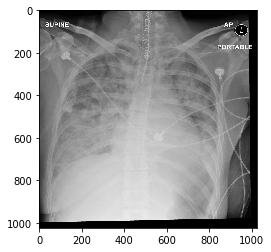

In [68]:
for valid_img_path in valid_imgs:
    
    img = Image.open(valid_img_path)
    plt.imshow(img)
    plt.show()
    
    break

In [74]:
PATH_TO_LABELS = './label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

def load_image_into_numpy_array(image):
    
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    
    with graph.as_default():
        with tf.Session() as sess:
            
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                    
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1]
                )
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
                
    return output_dict

IMAGE_SIZE = (1024, 1024)

In [75]:
for valid_img_path in valid_imgs:
    
    image = Image.open(valid_img_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    #image_np = load_image_into_numpy_array(image)
    image_np = np.array(image).astype(np.uint8)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8
    )
    #plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
    
    break

KeyError: "The name 'image_tensor:0' refers to a Tensor which does not exist. The operation, 'image_tensor', does not exist in the graph."